In [1]:
from Notebooks.cifar10_import import *
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate

## "Airplane" or "Banana": Classifying CIFAR-10

| Colin Yee, Reece Buyan, Ky-Vinh Mai

#### Summary

Our project is to create strategies to best classify images in the CIFAR-10 dataset using different classification models. Our classification models are:
1. Logisitic Regression
2. K-Nearest Neighbor
3. Feedforward Neural Network
4. Convolution Neural Network

From our experiments we concluded that:
- Logisitic Regression
- K-Nearest Neighbor
- Feedforward Neural Network
- Convolution Neural Network

#### Data Description

**CIFAR-10** consists of 60,000 colored images (32 x 32). Each image is labeled with one of 10 mutually exclusive classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck) 

https://paperswithcode.com/dataset/cifar-10

In [2]:
"""
By default, there are 50,000 images in the training set and 10,000 images in the testing set.
However, we will be combining these two sets to explore the entire dataset together.
"""
x_images, y_labels = importCifar10("combined")

Here are some facts about the CIFAR-10 dataset:

In [3]:
"""
Each "image" in the dataset is a (32 x 32 x 3) numpy matrix. Each slot in the (32 x 32) represents a pixel.
The 3-size array in each pixel represents an RGB color.
"""
x_images[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [4]:
"""
The y_labels consists of 60,000 numbers from 0 to 9. Each number represents a different image label.
"""
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
y_uniq_labels = np.unique(y_labels)
for c,y in zip(class_names,y_uniq_labels):
    print(c,y)

airplane 0
automobile 1
bird 2
cat 3
deer 4
dog 5
frog 6
horse 7
ship 8
truck 9


<BarContainer object of 10 artists>

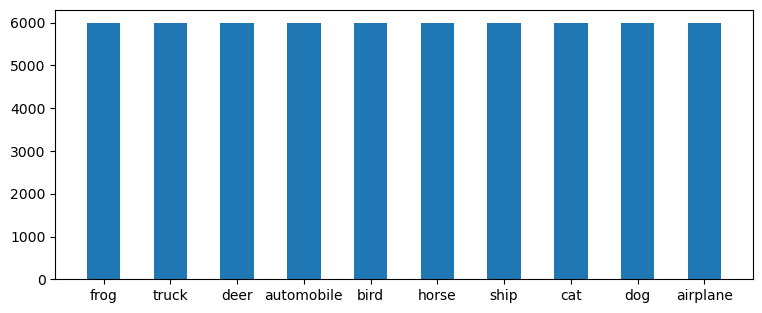

In [5]:
# Dataset contains same amount of images for each class
y_distribution = defaultdict(int)
for y in y_labels:
    y_distribution[class_names[y]]+=1

names = list(y_distribution.keys())
values = list(y_distribution.values())

fig = plt.figure(figsize=(9,3.5))
plt.bar(names,values,width=0.5)

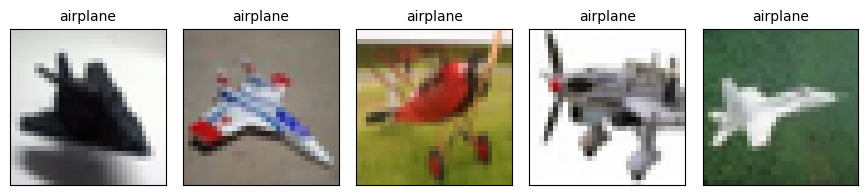

In [6]:
# Colors and backgrounds for each image may vary to some degree, but the object in each image follow a similar shape.
# That doesn't mean color and background has little role in the classification process...[INSERT MORE]
displayImages(5,x_images,y_labels,0)

"""
I tried to find the top 5 dominant colors in images of a certain class.
But I don't think it's that accurate.
"""
from sklearn.cluster import KMeans

def find_dominant_colors(images:np.array, num_colors = 5):
    flattened_colors = [image.reshape(-1,3) for image in images]
    combined_colors = np.concatenate(flattened_colors,axis=0)
    kmeans = KMeans(n_clusters=num_colors,n_init='auto')
    kmeans.fit(combined_colors)
    print("-- Computed K-Nearest Neighbor Model")
    dominant_colors = kmeans.cluster_centers_.astype(int)
    print("-- Determined Dominant Colors")
    return dominant_colors

plt.figure(figsize=(15,15))
i = 1
for c in y_uniq_labels:
    print(f"{c}: {class_names[c]}")
    indices = np.where(y_labels == c)
    X_c = x_images[indices]
    dominant_colors = find_dominant_colors(X_c,3)
    for r in dominant_colors:
        plt.subplot(12,12,i)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        color = np.zeros((32, 32, 3), dtype=np.uint8)
        color[:, :] = r
        plt.imshow(color)
        plt.title(class_names[c], fontsize=12)
        i+=1

#### Classifiers

In [7]:
def create_train_test_sets(x,y,scaled=True,gray=False):
    # Creating the training and testing sets (training is 60% of total)
    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.6,stratify=y_labels,shuffle=True)

    # Create Validation Set (50% of test set)
    X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.5,stratify=y_test,shuffle=True)

    if gray == True: X_train, X_val, X_test = grayScaleData(X_train, X_val, X_test)
    
    X_train, X_val, X_test = flattenImageSet(X_train,gray),flattenImageSet(X_val,gray),flattenImageSet(X_test,gray)

    if scaled == True:
        X_train, scalar = scaleImages(X_train)
        X_val = scaleImages(X_val,scalar)
        X_test = scaleImages(X_test,scalar)

    return (X_train, X_val, X_test, y_train, y_val, y_test)

In [8]:
# Create datasets for models and validation
X_train, X_val, X_test, y_train, y_val, y_test = create_train_test_sets(x_images,y_labels)
X_cleaned, y_cleaned = np.vstack((X_train,X_val,X_test)),\
      np.hstack((y_train,y_val,y_test))
X_test_only, y_test_only = np.vstack((X_val,X_test)),np.hstack((y_val,y_test))

In [9]:
y_test_only.shape

(36000,)

*`K` Nearest Neighbor*

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

We trained the CIFAR-10 dataset on a K-Nearest Neighbor (kNN) Classifier. The kNN classifier works by calculating the distance between a new datapoint (e.g. image) and all the other data points in the training set. It finds the K nearest data points based on the distance and assigns the majority class (e.g. label) among these neighbors to the new data point.

The hyperparameters that we will be experimenting on is:
* `n_neighbors` {x > 0, x <= size of dataset}: The number of neighbors closest to a new data point that will determine its class.
* `weights` ['uniform', 'distance']: Weight/influence of neighbors in determining a point's class.


In addition, I will be experimenting with the model and dataset configuation to determine what's best for the given dataset. These ideas are:
1. Dimensionality Reduction (RBG vs Grayscaled images)
2. Classification Reduction (1 Multi-Classification Model vs 10 Binary Classifcation Models)

We will experiment [INSERT SETUP LIKE WITH TRAINING PARTITIONG AND ETC.]

In [11]:
"""
kNN Helper Functions
"""
def plot_error_knn():
    pass
def cross_validate_knn():
    pass
def compute_accuracy_knn(
        x_train, x_test,
        y_train, y_test,
        conf_matrix = False,
        c = None
):
    pass

In [12]:
k_range = list(range(1, 10, 2))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)

In [13]:
knn = KNeighborsClassifier(n_neighbors=5)
grid = GridSearchCV(knn, param_grid, cv=4, scoring='accuracy', return_train_score=False)
grid.fit(X_cleaned,y_cleaned)

In [ ]:
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

In [ ]:
print(grid.best_score_)
print(grid.best_params_)